In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

2023-12-09 02:58:53.999928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 02:58:53.999957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 02:58:54.000897: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 02:58:54.005858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 02:59:01.917073: W tensorflow/compiler/tf2

In [2]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
True


2023-12-09 02:59:09.226798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-09 02:59:09.243600: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-09 02:59:09.243875: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset-1",
    shuffle=True,
    image_size=(224,224),
    batch_size=32,
    label_mode="categorical",
)

class_names = dataset.class_names
print("Number of classes:", len(class_names))

Found 16840 files belonging to 31 classes.


2023-12-09 02:59:10.095581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-09 02:59:10.096028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-09 02:59:10.096406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Number of classes: 31


In [5]:
class_names

['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Chicken Pox and Measles',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Monkey Pox',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections',
 'bags',
 'bopeng',
 'bru

In [6]:
# Define the function to split the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def split_dataset(base_dir, img_height, img_width, batch_size):
    # Advanced data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    val_test_datagen = ImageDataGenerator(rescale=1./255)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)



    return train_dataset, val_dataset, test_dataset

In [7]:
# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [8]:
# Fine-tuning: Unfreeze some of the top layers
base_model.trainable = True
fine_tune_at = 100  # Fine-tune from this layer onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [9]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(31, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:

# Split the dataset
train_dataset, val_dataset, test_dataset = split_dataset('dataset-1', 224, 224, 32)


In [12]:
if tf.config.list_physical_devices('GPU'):
    device_name = '/GPU:0'
else:
    device_name = '/CPU:0'
print('Using device:', device_name)

Using device: /GPU:0


In [13]:
with tf.device(device_name):
    history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    verbose=1 #it will show the progress bar
)

Epoch 1/50


2023-12-09 02:59:22.517214: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-09 02:59:25.050920: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2023-12-09 02:59:25.935459: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa1f87426a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-09 02:59:25.935481: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-12-09 02:59:25.940327: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702070965.999551   32335 device_compiler.h:186] Compiled cluster using XL

368/368 [==============================] - 85s 182ms/step - loss: 2.6394 - accuracy: 0.2508 - val_loss: 2.1404 - val_accuracy: 0.3734
Epoch 2/50
368/368 [==============================] - 109s 296ms/step - loss: 2.0052 - accuracy: 0.4147 - val_loss: 1.8763 - val_accuracy: 0.4470
Epoch 3/50
368/368 [==============================] - 93s 245ms/step - loss: 1.6363 - accuracy: 0.5131 - val_loss: 1.7310 - val_accuracy: 0.4933
Epoch 4/50
368/368 [==============================] - 78s 208ms/step - loss: 1.3443 - accuracy: 0.5962 - val_loss: 1.6271 - val_accuracy: 0.5320
Epoch 5/50
368/368 [==============================] - 123s 335ms/step - loss: 1.0654 - accuracy: 0.6759 - val_loss: 1.6234 - val_accuracy: 0.5403
Epoch 6/50
368/368 [==============================] - 52s 140ms/step - loss: 0.8348 - accuracy: 0.7447 - val_loss: 1.6550 - val_accuracy: 0.5538
Epoch 7/50
368/368 [==============================] - 51s 139ms/step - loss: 0.6473 - accuracy: 0.8031 - val_loss: 1.6589 - val_accuracy: 0

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

80/80 [==============================] - 13s 61ms/step - loss: 2.9563 - accuracy: 0.5710
Test Loss: 2.9563210010528564, Test Accuracy: 0.5709779262542725


In [37]:
model.get_weights()

[array([0.485, 0.456, 0.406], dtype=float32),
 array([0.229, 0.224, 0.225], dtype=float32),
 0,
 array([[[[ 2.07668245e-02,  8.53624821e-01, -9.72171009e-01,
            5.80005467e-01,  3.13335508e-02, -1.81043148e-02,
           -1.28635168e-02,  5.94060645e-02, -7.41896749e-01,
           -2.27897346e-01,  2.00766921e-01, -2.33019665e-02,
           -3.82314444e-01, -1.13366711e+00, -4.97356057e-02,
           -5.28575480e-01,  6.01686649e-02,  3.28413874e-01,
            7.26403654e-01,  9.56093222e-02,  2.53003836e-03,
            7.99428642e-01,  1.60467178e-01,  1.51992925e-02,
            2.15564728e-01, -6.15406692e-01,  7.56446272e-02,
            3.47692966e-02,  0.00000000e+00, -6.27994761e-02,
            2.23197415e-02, -1.42137900e-01],
          [ 1.28902495e-02,  1.56575632e+00, -1.80467033e+00,
            7.77730107e-01,  6.52952865e-02,  2.08790317e-01,
           -8.81190374e-02, -3.78276139e-01,  5.80090940e-01,
           -3.44047934e-01,  6.91463649e-02, -8.7926

In [29]:
model.save("model.hd5", save_format="h5")

/home/rikato/Code+Notes/PIWOT-2023/cuda_gpu_computation/myenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
from tensorflow.keras.preprocessing import image
from joblib import load

# loaded_model = load('model.joblib')


# Load your trained model from the HDF5 file
model_path = r"model.hd5"  # Replace with the actual path to your HDF5 file
loaded_model = tf.keras.models.load_model(model_path)


# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Assuming your model expects 224x224 images
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # img_array /= 255.0  # Normalize pixel values to the range [0, 1]
    return img_array

# Function to make predictions on an image
def predict_image(model, image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions)
    return predicted_class

# Path to the image you want to predict
image_to_predict_path = r"dataset-1/Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions/actinic-cheilitis-sq-cell-lip-1.jpg"  # Replace with the actual path to your image C:\Coding\skin_disease\dataset-1\Nail Fungus and other Nail Disease

# Make a prediction
predicted_class = predict_image(loaded_model, image_to_predict_path)
print(predicted_class)
#avaliable_class=['Acne and Rosacea Photos','Actinic_keratosis','Atopic Dermatitis Photos','Basal_cell_carcinoma','Bullous Disease Photos','Dermatofibroma','Eczema Photos','Exanthems and Drug Eruptions','Hair Loss Photos Alopecia and other Hair Diseases','Herpes HPV and other STDs Photos','Light Diseases and Disorders of Pigmentation','Lupus and other Connective Tissue diseases','Melanoma','Melanoma Skin Cancer Nevi and Moles','Monkey Pox','Nail Fungus and other Nail Disease','Psoriasis pictures Lichen Planus and related diseases','Scabies Lyme Disease and other Infestations and Bites','Seborrheic Keratoses and other Benign Tumors','Urticaria Hives','Vascular Tumors','Vasculitis Photos','bags','benign_keratosis','bopeng','bruntusan','chicken  pox and measles','cystic','melanotic_nevus','papula','pustula']

# Print or use the predicted class as needed
print("Predicted Class:", predicted_class)
#print("Predicted Class:", avaliable_class[predicted_class-1])



1/1 [==============================] - 1s 1s/step
1
Predicted Class: 1


First image to predict:


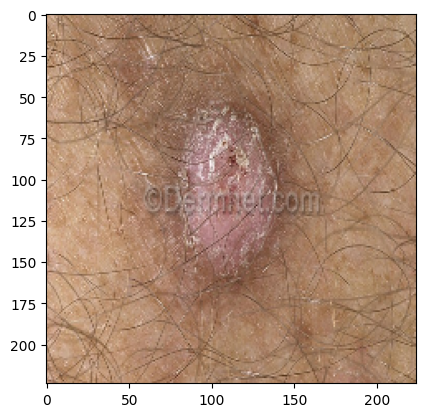

Actual label: Exanthems and Drug Eruptions
1/1 [==============================] - 1s 1s/step
Predicted label: Seborrheic Keratoses and other Benign Tumors


In [34]:
import numpy as np
classes_names = ['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Chicken Pox and Measles',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Monkey Pox',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections',
 'bags',
 'bopeng',
 'bruntusan',
 'cystic',
 'papula',
 'pustula']
# Predict and visualize the result of a single image from a batch
for image_batch, labels_batch in test_dataset.take(1):
    first_image = image_batch[2].numpy().astype('uint8')
    first_label = np.argmax(labels_batch[10].numpy())  # Use argmax for one-hot encoded labels

    print("First image to predict:")
    plt.imshow(first_image)
    plt.show()
    print("Actual label:", classes_names[first_label])
    
    # Batch prediction
    batch_prediction = model.predict(image_batch)
    print("Predicted label:", classes_names[np.argmax(batch_prediction[10])])

First image to predict:


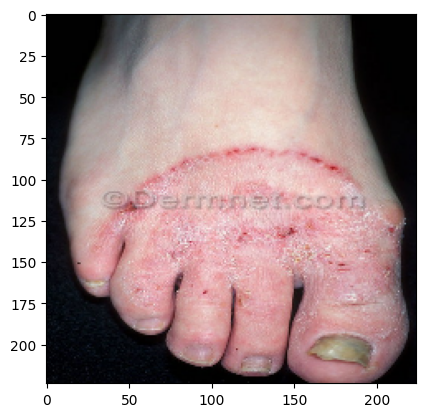

Actual label: Tinea Ringworm Candidiasis and other Fungal Infections
1/1 [==============================] - 0s 27ms/step
Predicted label: Tinea Ringworm Candidiasis and other Fungal Infections


In [23]:
# Predict and visualize the result of a single image from a batch
for image_batch, labels_batch in test_dataset.take(1):
    first_image = image_batch[6].numpy().astype('uint8')
    first_label = np.argmax(labels_batch[6].numpy())  # Use argmax for one-hot encoded labels

    print("First image to predict:")
    plt.imshow(first_image)
    plt.show()
    print("Actual label:", classes_names[first_label])
    
    # Batch prediction
    batch_prediction = model.predict(image_batch)
    print("Predicted label:", classes_names[np.argmax(batch_prediction[6])])

In [25]:
!pip install joblib

  Obtaining dependency information for joblib from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [26]:
from joblib import dump

# Assume 'model' is your scikit-learn model
dump(model, 'model.joblib')

['model.joblib']